# Entanglement between the two registers

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.aer.library import SaveDensityMatrix
from qiskit.visualization import array_to_latex
import qiskit.quantum_info as qi
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.operators import Operator
from qiskit import execute, transpile, assemble
from qiskit import Aer
from qiskit.visualization import plot_histogram
from sympy import factorint
from numpy import linalg
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
from sympy import *
import random
from random import sample
import math

In [2]:
def check(number):
    if number % 2 == 0:
        print("Even, 2 is a divisor")
        return
        
    if isprime(number) == True:
        print("Prime number")
        return
    
    factorization = factorint(number)
    for i in range(len(factorization.keys())):
        p = list(factorization)[i]
        q = list(factorization.values())[i]
        if isprime(p) and q != 1:
            print("Prime Power: %i^%i, %i is a divisor" % ( p, q, p))
            return
    
    y = random.randrange(2, number - 1)
    a = math.gcd(y, number)
    if a > 1:
        print("Divisor: a = %i" %(a))
        return y
        
    else:
        print("y = %i and N = %i are coprime - r well defined" %  (y, N))
        return 

In [3]:
def mod_exp(n, y, N, power):
    dim = 2**n
    matrix = np.zeros((dim, dim))
    
    for i in range(N):
        j = (i*y)%N
        matrix[j][i]=1
             
    for ii in range(N, dim):
        matrix[ii][ii] = 1
             
    matrix = linalg.matrix_power(matrix, 2**power) 
        
    U = UnitaryGate(matrix)
    
    U.name = "%i^%i mod %i" % ( y, 2**power, N)
    c_U = U.control()
    return c_U

In [4]:
def qft_dagger(n):
    qc = QuantumCircuit(n)

    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [5]:
N = 15

In [6]:
check(N)

y = 4 and N = 15 are coprime - r well defined


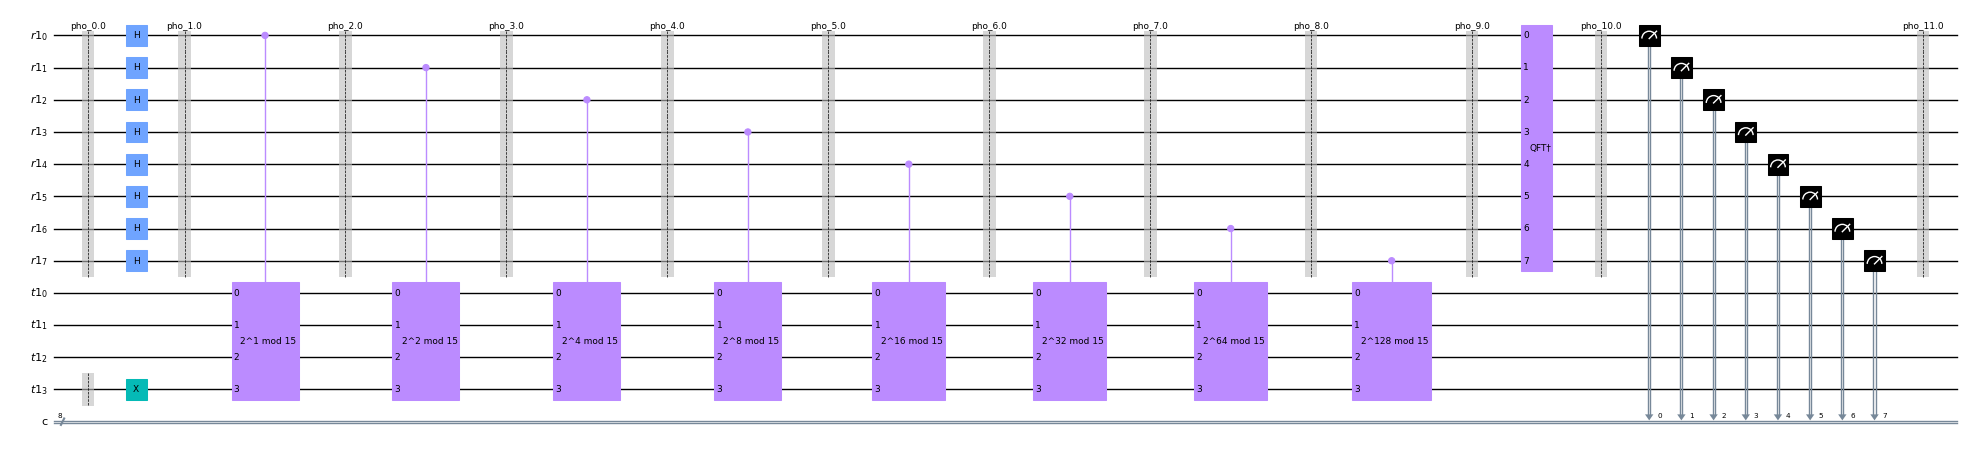

In [17]:
y = 2  
N = 15 

n = math.ceil(math.log(N,2))
control = QuantumRegister(2*n, 'r1')
target  = QuantumRegister(n, 't1')
classic = ClassicalRegister(2*n, 'c')
circuit = QuantumCircuit(control, target, classic)
qubits = control
size = len(qubits)
label = 0
circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])
circuit.barrier(3*n - 1)
circuit.h(range(2*n))
circuit.x(2*n + n -1)
label += 1
circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])

for q in range(2*n):
    label += 1
    circuit.append(mod_exp(n, y, N, q), [q] + [i+2*n for i in range(n)]) 
    circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])
    
circuit.append(qft_dagger(2*n), range(2*n)) 
label += 1
circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])


circuit.measure(control, classic)
label += 1
circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])
circuit.draw( fold = -1,output = 'mpl', scale = 0.5) 

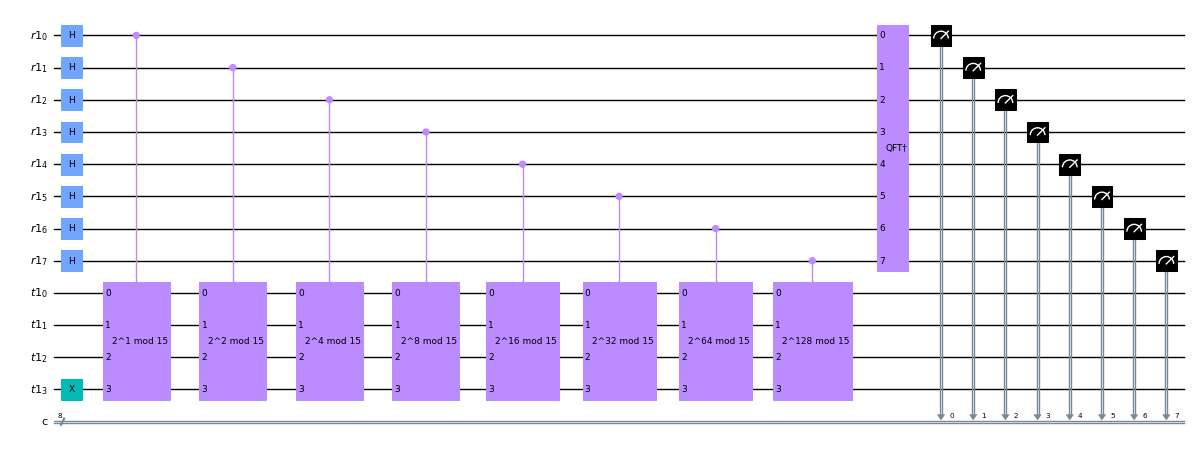

In [19]:
from qiskit.tools.visualization import circuit_drawer
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(16, 6))

circuit_drawer(circuit, output='latex_source',filename = 'shor.tex', style={'backgroundcolor': '#EEEEEE'}, plot_barriers=False)
circuit.draw('mpl', fold = -1, scale = 0.5, plot_barriers=False)

In [18]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(circuit, aer_sim)
qobj = assemble(t_qc)                                
results = aer_sim.run(qobj, shots = 1).result()     #shots = 1!

counts = results.get_counts()

labels = []
for i in range(len(counts)):
    labels.append(   int(list(counts.keys())[i], 2 )   )
    
new_counts = dict(zip(labels,list(counts.values()) ))

In [37]:
entropies = []
xs = []
for i in range (label+1):
    density_matrix = results.data()['pho_%.1f' % (i)]
    xs.append(i)
    entropies.append(qi.entropy(density_matrix))
    density_matrix = 0

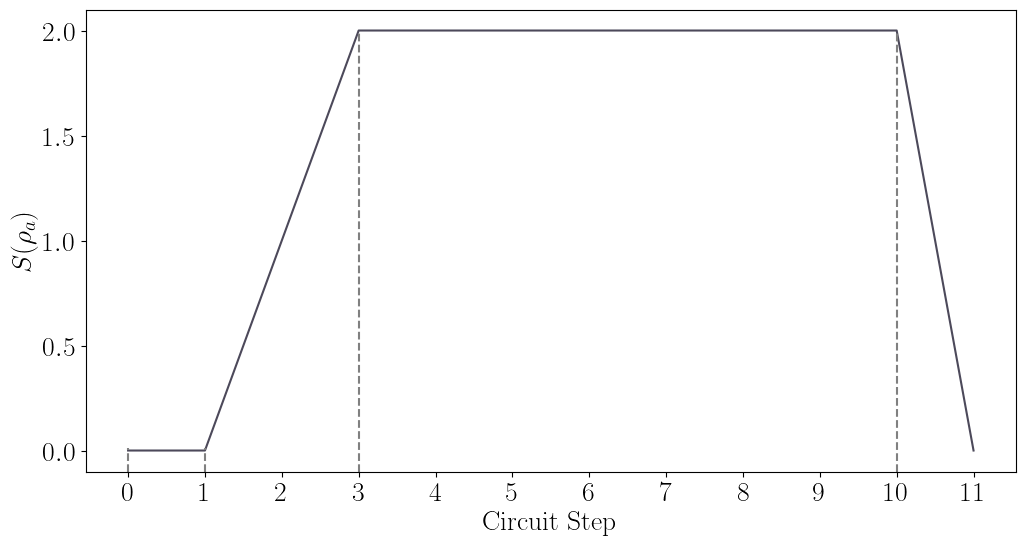

In [38]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 6))
params = {'text.usetex' : True, 'font.size' : 20, 'font.family' : 'serif'}
plt.rcParams.update(params)

plt.plot(entropies, color = '#4C495A')    
plt.xlabel('Circuit Step')
plt.ylabel(r"$S(\rho_a)$")
plt.xticks(xs)
plt.axvline(x = 0,  ymax = 0.05, linestyle='dashed', color = 'grey')
plt.axvline(x = 1,  ymax = 0.05, linestyle='dashed', color = 'grey')
plt.axvline(x = 3,  ymax = 0.95, linestyle='dashed', color = 'grey')
plt.axvline(x = 10, ymax = 0.95, linestyle='dashed', color = 'grey')
plt.savefig('shor_ent_registers.pdf', format = 'pdf')
plt.show()